# Résolution de problèmes par l'exploration

Dans ce sujet de TP, sur 4 séances, nous allons voir comment implémenter la formalisation d'un problème de résolution par l'exploration ainsi que les différents algorithmes de recherche vus en cours puis en TD. Nous verrons enfin comment utiliser cela pour effectuer la résolution de labyrinthes et de jeux de taquin.


In [41]:
from numpy.random import randint
import matplotlib.pyplot as plt
import random
import heapq
import math
import sys
from collections import defaultdict, deque, Counter
from itertools import combinations
from queue import PriorityQueue

# Définition d'un problème

On commence par définir une classe abstraite pour représenter un `Problem` qui sera résolu par l'exploration.

On indique l'état initial et soit l'état final (s'il y en a un seul), soit la manière de savoir si on se trouve dans un état final (en redéfinissant la méthode `is_goal`, dans la sous-classe qui implémente la classe `Problem`). La sous-classe devra également implémenter le constructeur `__init__`(en ajoutant éventuellement d'autres paramètres) et les méthodes `actions`, `result` et `action_cost`. 


In [42]:
class Problem:
    """The abstract class for a formal problem. A new domain subclasses this,
    overriding `actions` and `results`, and perhaps other methods.
    The default action cost is 1 for all states.
    When you create an instance of a subclass, specify `initial`, and `goal` states 
    (or give an `is_goal` method) and perhaps other arguments for the subclass."""


    def __init__(self, initial=None, goal=None): 
        """The constructor specifies the initial state, and possibly a goal
        state, if there is a unique goal. Your subclass's constructor can add
        other arguments."""
        self.initial = initial
        self.goal = goal
        
    def actions(self, state):     
        """Return the actions that can be executed in the given
        state. The result would typically be a list, but if there are
        many actions, consider yielding them one at a time in an
        iterator, rather than building them all at once."""   
        raise NotImplementedError
    
    def result(self, state, action): 
        """Return the state that results from executing the given
        action in the given state. The action must be one of
        self.actions(state)."""
        raise NotImplementedError
    
    def is_goal(self, state):   
        """Return True if the state is a goal. The default method compares the
        state to self.goal or checks for state in self.goal if it is a
        list, as specified in the constructor."""     
        return state == self.goal
    
    def action_cost(self, s, a, s1): 
        """Return the cost of an action a from state s to state s1."""
        return 1
    
    def __str__(self):
        return '{}({!r}, {!r})'.format(
            type(self).__name__, self.initial, self.goal)

# Définition d'un arbre de recherche

Un arbre de recherche est défini par la classe `Node`, qui définit le noeud racine de l'arbre de recherche et ses sous-arbres fils.

## Définition d'un noeud

Dans la classe `Node`, on définit un noeud dans un arbre de recherche.
Le noeud contient un pointeur vers son noeud parent `parent` ainsi que vers l'état `state` auquel il correspond (la notion d'état sera défini au moment de la définition du problème représenté). Il est à noter que si un état peut être atteint par 2 chemins, il y aura alors 2 noeuds contenant le même état. Le noeud contient également l'action `action` qui a permis d'atteindre l'état associé au noeud ainsi que le coût total `path_cost` du chemin allant du noeud initial au noeud courant (correspondant à la valeur g dans les algorithmes d'exploration).

In [43]:
class Node:
    "A Node in a search tree."
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost

    def __repr__(self): 
        return '<{}>'.format(self.state)
    
    def __len__(self): 
        return 0 if self.parent is None else (1 + len(self.parent))
    
    def __lt__(self, other): 
        return self.path_cost < other.path_cost
    

## Fonctions relatives aux noeuds d'un arbre de recherche

On définit également quelques fonctions sur les noeuds : `expand` pour générer les noeuds successeurs d'un noeud donné, `path_actions` pour récupérer la liste d'actions ayant permis d'arriver jusqu'au noeud et `path_states` pour récupérer la liste des états ayant permis d'arriver jusqu'au noeud.

### Question 3 : compléter ces 3 fonctions

In [44]:
def expand(problem, node):
    "Expand a node, generating the children nodes (see slide 18 in the lecture)."
    successors = []

    for action in problem.actions(node.state):
        next_state = problem.result(node.state, action)
        cost = node.path_cost + problem.action_cost(node.state, action, next_state)
        child_node = Node(next_state, node, action, cost)
        successors.append(child_node)

    return successors
        

def path_actions(node):
    if node.parent is None:
        return []
    else:
        return path_actions(node.parent) + [node.action]

def path_states(node):
    if node.parent is None:
        return [node.state]
    else:
        return path_states(node.parent) + [node.state]

# Algorithmes de recherche

Les algorithmes de recherche non-informée (exploration en largeur et exploration en profondeur, en mémorisant ou non les états déjà exploras) ainsi que les algorithmes de recherche informée (exploration gloutonne et A*) seront implémentés ici.

In [45]:
# Noeud particulier pour indiquer qu'un algorithme ne peut pas trouver de solution    
failure = Node('failure', path_cost=math.inf)

## Différents types de files pour implémenter la frontière

Les files FIFO et LIFO sont utilisées, respectivement, pour implémenter la `frontière` dans l'exploration en largeur et dans l'exploration en profondeur. La file de priorié `PriorityQueue` est utilisée dans l'exploration gloutonne et dans l'exploration A* pour garder la frontière triée en fonction du score croissant `f(item)`.

In [46]:
FIFOQueue = deque

LIFOQueue = list


## Exploration en largeur de l'arbre de recherche

### Question 5 : implémenter l'exploration en largeur de l'arbre de recherche (voir slides 18 et 20 du cours)

In [47]:
def breadth_first_tree_search(problem):
    """Search the shallowest nodes in the search tree first.
    Search through the successors of a problem to find a goal.
    The argument frontier should be an empty queue.
    Repeats infinitely in case of loops."""

    frontiere = LIFOQueue()
    frontiere.append(Node(problem.initial))

    nodes_generated = 1  # compteur de noeuds générés
    nodes_visited = 0    # compteur de noeuds visités

    while frontiere:
        node = frontiere.pop(0)
        nodes_visited += 1
        if problem.is_goal(node.state):
            return node, nodes_generated, nodes_visited
        successors = expand(problem, node)
        nodes_generated += len(successors)
        frontiere.extend(successors)
    return failure, nodes_generated, nodes_visited

## Exploration en profondeur de l'arbre de recherche

### Question 7 : implémenter l'exploration en profondeur de l'arbre de recherche (voir slides 18 et 21 du cours)

In [48]:
def depth_first_tree_search(problem):
    """Search the deepest nodes in the search tree first.
    Search through the successors of a problem to find a goal.
    The argument frontier should be an empty queue.
    Repeats infinitely in case of loops.
    """

    frontiere = FIFOQueue()

    frontiere.append(Node(problem.initial))

    while frontiere:
        node = frontiere.pop()
        if problem.is_goal(node.state):
            return node
        frontiere.extend(expand(problem, node))

    return failure

## Exploration en largeur du graphe des états

### Question 8 : implémenter l'exploration en largeur du graphe des états (voir slide 27 du cours)

In [49]:
def breadth_first_graph_search(problem):
    """Search the shallowest nodes in the search tree first.
    Search through the successors of a problem to find a goal.
    The argument frontier should be an empty queue.
    Does not get trapped by loops.
    If two paths reach a state, only use the first one.
    """

    frontiere = FIFOQueue()
    frontiere.append(Node(problem.initial))

    liste_fermes = set()
    etat_frontiere = {problem.initial}

    nodes_generated = 1  # compteur de noeuds générés
    nodes_visited = 0    # compteur de noeuds visités

    while frontiere:
        if not frontiere:
            return failure, nodes_generated, nodes_visited

        node = frontiere.popleft()
        nodes_visited += 1

        if problem.is_goal(node.state):
            return node, nodes_generated, nodes_visited

        liste_fermes.add(node.state)
        etat_frontiere.discard(node.state)

        for child in expand(problem, node):
            if child.state not in liste_fermes and child.state not in etat_frontiere:
                frontiere.append(child)
                etat_frontiere.add(child.state)
                nodes_generated += 1
    return failure, nodes_generated, nodes_visited

## Exploration en profondeur du graphe des états

### Question 9 : implémenter l'exploration en profondeur du graphe des états (voir slide 27 du cours)

In [50]:
def depth_first_graph_search(problem):
    """Search the deepest nodes in the search tree first.
    Search through the successors of a problem to find a goal.
    The argument frontier should be an empty queue.
    Does not get trapped by loops.
    If two paths reach a state, only use the first one.
    """
    frontiere = LIFOQueue()
    frontiere.append(Node(problem.initial))
    liste_fermes = set()

    while frontiere:
        if not frontiere:
            return failure

        node = frontiere.pop()

        if problem.is_goal(node.state):
            return node, liste_fermes

        liste_fermes.add(node.state)

        for child in expand(problem, node):
            if child.state not in liste_fermes or child.state not in [n.state for n in frontiere]:
                frontiere.append(child)
            elif child.state in frontiere and child.path_cost < [n for n in frontiere if n.state == child.state][0].path_cost:
                frontiere.remove([n for n in frontiere if n.state == child.state][0])
                frontiere.append(child)
    return failure

## Exploration gloutonne du graphe des états

### Question 10 : implémenter l'exploration gloutonne du graphe des états (voir slides 27 et 34 du cours)

In [71]:
def greedy_graph_search(problem, h=None):
    """Search nodes with minimum h(n)."""
    if h is None:
        h = problem.h

    frontiere = []
    initial_node = Node(problem.initial)
    heapq.heappush(frontiere, (h(initial_node), initial_node))
    liste_fermes = set()
    etat_frontiere = {problem.initial}

    nodes_generated = 1  # compteur de noeuds générés
    nodes_visited = 0    # compteur de noeuds visités

    while frontiere:
        _, node = heapq.heappop(frontiere)

        # Vérifier si ce noeud est toujours dans la frontière (pas déjà traité)
        if node.state in liste_fermes:
            continue

        nodes_visited += 1

        if problem.is_goal(node.state):
            return node, nodes_generated, nodes_visited

        liste_fermes.add(node.state)
        etat_frontiere.discard(node.state)

        for child in expand(problem, node):
            if child.state not in liste_fermes and child.state not in etat_frontiere:
                heapq.heappush(frontiere, (h(child), child))
                etat_frontiere.add(child.state)
                nodes_generated += 1
    return failure, nodes_generated, nodes_visited

## Exploration A* du graphe des états

### Question 11 : implémenter l'exploration A* du graphe des états (voir slides 27 et 37 du cours)

In [72]:
def astar_graph_search(problem, h=None):
    """Search nodes with minimum f(n) = g(n) + h(n)."""
    if h is None:
        h = problem.h

    frontiere = []
    initial_node = Node(problem.initial)
    f_initial = initial_node.path_cost + h(initial_node)
    heapq.heappush(frontiere, (f_initial, initial_node))
    liste_fermes = set()
    etat_frontiere = {problem.initial: initial_node}  # Dictionnaire : état -> noeud

    nodes_generated = 1  # compteur de noeuds générés
    nodes_visited = 0    # compteur de noeuds visités

    while frontiere:
        _, node = heapq.heappop(frontiere)

        # Vérifier si ce noeud est toujours dans la frontière (pas déjà traité)
        if node.state in liste_fermes:
            continue

        nodes_visited += 1

        if problem.is_goal(node.state):
            return node, nodes_generated, nodes_visited

        liste_fermes.add(node.state)
        if node.state in etat_frontiere:
            del etat_frontiere[node.state]

        for child in expand(problem, node):
            if child.state not in liste_fermes:
                f_child = child.path_cost + h(child)

                if child.state not in etat_frontiere:
                    heapq.heappush(frontiere, (f_child, child))
                    etat_frontiere[child.state] = child
                    nodes_generated += 1
                elif child.path_cost < etat_frontiere[child.state].path_cost:
                    # Mettre à jour avec un meilleur chemin
                    etat_frontiere[child.state] = child
                    heapq.heappush(frontiere, (f_child, child))
    return failure, nodes_generated, nodes_visited

# Résolution de labyrinthes

La résolution d'un problème de type labyrinthe implique de naivguer dans une grille 2D avec des cases pouvant contenir des murs dans les 4 directions autour de chaque case (nord, est, sud et ouest). 

## Définition d'une classe représentant un labyrinthe

On commence par définir la classe `Cell` (pour représenter les cases d'un labyrinthe) puis la classe `Labyrinth` pour représenter le labyrinthe constitué de cases.

In [53]:
from numpy.random import randint
import matplotlib.pyplot as plt


class Stack:
    """ définition d'une pile à l'aide de la classe List """
    def __init__(self):
        self.lst = []

    def empty(self):
        return self.lst == []

    def push(self, x):
        self.lst.append(x)

    def pop(self):
        if self.empty():
            raise ValueError("pile vide")
        return self.lst.pop()


class Cell:
    def __init__(self, N=False, E=False, S=False, W=False):
        self.N = N
        self.E = E
        self.S = S
        self.W = W
    

class Labyrinth:
    def __init__(self, p, q, tab=None):
        self.p = p
        self.q = q
        if tab == None:
            self.tab = [[Cell() for j in range(q)] for i in range(p)]
        else:
            self.tab = tab
        
    def entrance(self):
        return (0, 0)

    def exit(self):
        return (self.p-1, self.q-1)

    def create(self):
        pile = Stack()
        dejavu = [[False for j in range(self.q)] for i in range(self.p)]
        i, j = randint(self.p), randint(self.q)
        pile.push((i, j))
        dejavu[i][j] = True
        while not pile.empty():
            (i, j) = pile.pop()
            v = []
            if j < self.q-1 and not dejavu[i][j+1]:
                v.append('E')
            if i > 0 and not dejavu[i-1][j]:
                v.append('N')
            if j > 0 and not dejavu[i][j-1]:
                v.append('W')
            if i < self.p-1 and not dejavu[i+1][j]:
                v.append('S')
            if len(v) > 1:
                pile.push((i, j))
            if len(v) > 0:
                c = v[randint(len(v))]
                if c == 'N':
                    self.tab[i][j].N = True
                    self.tab[i-1][j].S = True
                    dejavu[i-1][j] = True
                    pile.push((i-1, j))
                elif c == 'W':
                    self.tab[i][j].W = True
                    self.tab[i][j-1].E = True
                    dejavu[i][j-1] = True
                    pile.push((i, j-1))
                elif c == 'S':
                    self.tab[i][j].S = True
                    self.tab[i+1][j].N = True
                    dejavu[i+1][j] = True
                    pile.push((i+1, j))
                else:
                    self.tab[i][j].E = True
                    self.tab[i][j+1].W = True
                    dejavu[i][j+1] = True
                    pile.push((i, j+1))

    def show(self, sol=Stack()):
        fig = plt.figure(1, figsize=(self.q/3.2, self.p/3.2))
        ax = fig.add_subplot(111)
        ax.axis([-1, self.q+1, -1, self.p+1])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.plot([0, 0, self.q, self.q, 0],
                 [0, self.p, self.p, 0, 0], linewidth=2)
        for i in range(self.p-1):
            for j in range(self.q):
                if not self.tab[i][j].S:
                    ax.plot([j, j+1], [self.p-i-1, self.p-i-1], 'b')
        for j in range(self.q-1):
            for i in range(self.p):
                if not self.tab[i][j].E:
                    ax.plot([j+1, j+1], [self.p-i, self.p-i-1], 'b')
        if not sol.empty():
            X, Y = [], []
            while not sol.empty():
                (i, j) = sol.pop()
                X.append(j+.5)
                Y.append(self.p-i-.5)
            ax.plot(X, Y, 'r', linewidth=2)
        plt.show()

### Test de la classe Labyrinth

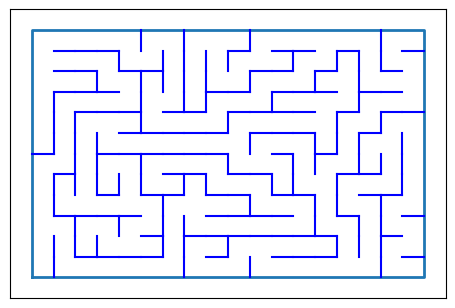

entrée : (0, 0)
sortie : (11, 17)


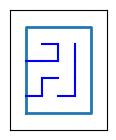

False
entrée : (0, 0)
sortie : (4, 3)


In [54]:
# création et affichage d'un labyrinthe généré aléatoirement à partir de la taille souhaitée
lab1 = Labyrinth(12, 18)
lab1.create()
lab1.show()

print("entrée : " + str(lab1.entrance()))
print("sortie : " + str(lab1.exit()))


# création et affichage d'un labyrinthe à partir d'un tableau de cellules, indiquant les murs autour de chaque case
tab = [
    [Cell(False, True, True, False), Cell(False, True, False, True), Cell(False, True, True, True), Cell(False, False, True, True)],
    [Cell(True, True, False, False), Cell(False, False, False, True), Cell(True, False, True, False), Cell(True, False, True, False)],
    [Cell(False, True, True, False), Cell(False, True, False, True), Cell(True, False, True, True), Cell(True, False, True, False)],
    [Cell(True, False, False, False), Cell(False, True, True, False), Cell(False, False, False, True), Cell(True, False, True, False)],
    [Cell(False, True, False, False), Cell(True, True, False, True), Cell(False, True, False, True), Cell(True, False, False, True)],
]

lab2 = Labyrinth(5, 4, tab)
lab2.show()
print(lab2.tab[0][0].N)

print("entrée : " + str(lab2.entrance()))
print("sortie : " + str(lab2.exit()))


## Définition d'une classe de résolution d'un labyrinthe

Il est nécessaire d'avoir un attribut `labyrinth` pour représenter le labyrinthe.

Les états sont les positions des cellules sous la forme `(x, y)`, comme par exemple, `(4, 2)`. 

Les actions peuvent, par exemple, être représentées par des chaînes de caractères `H`, `B`, `G` et `D`, correspondant aux actions "haut", "bas", "gauche" et "droite".

### Question 1 : compléter les méthodes de la classe `LabyrinthProblem`, en reprenant celles de la classe `Problem` que vous souhaitez implémenter

In [55]:
class LabyrinthProblem(Problem):
    
    def __init__(self, labyrinth):
        super().__init__(initial=labyrinth.entrance(), goal=labyrinth.exit())
        self.labyrinth = labyrinth
    
        
    def actions(self, state):
        """Return the actions that can be executed in the given
        state. The result would typically be a list, but if there are
        many actions, consider yielding them one at a time in an
        iterator, rather than building them all at once."""
        i, j = state
        actions = []

        if self.labyrinth.tab[i][j].N:
            actions.append('H')
        if self.labyrinth.tab[i][j].S:
            actions.append('B')
        if self.labyrinth.tab[i][j].W:
            actions.append('G')
        if self.labyrinth.tab[i][j].E:
            actions.append('D')

        return actions
    
    
    def result(self, state, action): 
        """Both states and actions are represented by (x, y) pairs. 
            On suppose que l'action est forcément possible, à partir de l'état state.
        """

        i, j = state

        if action == 'H':
            return i - 1, j
        elif action == 'B':
            return i + 1, j
        elif action == 'G':
            return i, j - 1
        elif action == 'D':
            return i, j + 1
        else :
            raise ValueError("action inconnue : " + str(action))
    
    
    def h(self, node):
        """The Manhattan heuristic."""
        i_end, j_end = self.goal
        i, j = node.state

        return abs(i - i_end) + abs(j - j_end)


# autres fonctions

def g(n): 
    return n.path_cost

### Question 2 : tester les méthodes implémentées dans la classe `LabyrinthProblem`, en utilisant le labyrinthe `lab2`

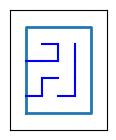

['B', 'D']
(1, 0)
(0, 1)
7


In [56]:
labProb2 = LabyrinthProblem(labyrinth=lab2)
labProb2.labyrinth.show()

init_state = labProb2.initial

# test de la méthode actions()
print(labProb2.actions(init_state)) # doit retourner ['D', 'B']

# test de la méthode result()
print(labProb2.result(init_state, 'B')) # doit retourner (1,0)
print(labProb2.result(init_state, 'D')) # doit retourner (0,1)

# test de la méthode h()
print(labProb2.h(Node(init_state))) # doit retourner 7

### Question 4 : tester les fonctions implémentées sur les noeuds (à la question 3)

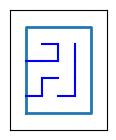

[<(1, 0)>, <(0, 1)>]
['D']
[(0, 0), (0, 1)]


In [57]:
labProb2 = LabyrinthProblem(labyrinth=lab2)
labProb2.labyrinth.show()

init_state = labProb2.initial
init_node = Node(init_state)
child_right = Node((0,1), init_node, 'D', 1)

# test de la fonction expand()
print(expand(labProb2, init_node)) # doit retourner [<(0, 1)>, <(1, 0)>], c'est-à-dire les noeuds correspondant aux états (0,1) et (1,0)

# test de la fonction path_actions()
print(path_actions(child_right)) # doit retourner 'D'

# test de la fonction path_states()
print(path_states(child_right)) # doit retourner [(0,0), (0,1)]

## Utilisation de différentes stratégies de résolution de labyrinthes

### Question 6 : tester la résolution de problèmes de labyrinthes, en utilisant la classe `LabyrinthProblem`, ainsi que les fonctions correspondant aux différents algorithmes de recherche + affichage du chemin parcouru, sur le labyrinthe

#### Exploration en largeur (en arbre)

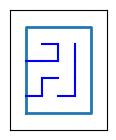


exploration en largeur (en arbre)
	états sur le chemin vers la sortie : [(0, 0), (0, 1), (0, 2), (0, 3), (1, 3), (2, 3), (3, 3), (4, 3)]
	actions sur le chemin vers la sortie : ['D', 'D', 'D', 'B', 'B', 'B', 'B']


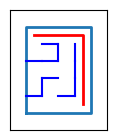

In [58]:
labProb2 = LabyrinthProblem(labyrinth=lab2)
labProb2.labyrinth.show()

print("\nexploration en largeur (en arbre)")
res2bt, nodes_gen_bt, nodes_vis_bt = breadth_first_tree_search(labProb2)
etats2bt = path_states(res2bt)
print("\tétats sur le chemin vers la sortie : " + str(etats2bt))
print("\tactions sur le chemin vers la sortie : " + str(path_actions(res2bt)))

pile_solution = Stack()
pile_solution.lst = etats2bt.copy()
labProb2.labyrinth.show(pile_solution)


#### Exploration en profondeur (en arbre)

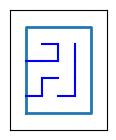


exploration en profondeur (en arbre)


KeyboardInterrupt: 

In [59]:
labProb2 = LabyrinthProblem(labyrinth=lab2)
labProb2.labyrinth.show()

print("\nexploration en profondeur (en arbre)")
res2dt = depth_first_tree_search(labProb2)
etats2dt = path_states(res2dt)
print("\tétats sur le chemin vers la sortie : " + str(etats2dt))
print("\tactions sur le chemin vers la sortie : " + str(path_actions(res2dt)))
pile_solution = Stack()
pile_solution.lst = etats2dt.copy()
labProb2.labyrinth.show(pile_solution)


### Exploration en largeur (en graphe)

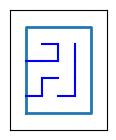


exploration en largeur (en graphe)
	états sur le chemin vers la sortie : [(0, 0), (0, 1), (0, 2), (0, 3), (1, 3), (2, 3), (3, 3), (4, 3)]
	actions sur le chemin vers la sortie : ['D', 'D', 'D', 'B', 'B', 'B', 'B']


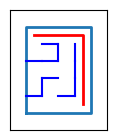

In [60]:
labProb2 = LabyrinthProblem(labyrinth=lab2)
labProb2.labyrinth.show()
print("\nexploration en largeur (en graphe)")
res2bg, nodes_gen_bg, nodes_vis_bg = breadth_first_graph_search(labProb2)
etats2bg = path_states(res2bg)
print("\tétats sur le chemin vers la sortie : " + str(etats2bg))
print("\tactions sur le chemin vers la sortie : " + str(path_actions(res2bg)))
pile_solution = Stack()
pile_solution.lst = etats2bg.copy()
labProb2.labyrinth.show(pile_solution)

##### Exploration en profondeur (en graphe)

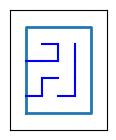


exploration en profondeur (en graphe)


KeyboardInterrupt: 

In [61]:
labProb2 = LabyrinthProblem(labyrinth=lab2)
labProb2.labyrinth.show()
print("\nexploration en profondeur (en graphe)")
res2dg, liste_fermes = depth_first_graph_search(labProb2)
etats2dg = path_states(res2dg)
print("\tétats sur le chemin vers la sortie : " + str(etats2dg))
print("\tactions sur le chemin vers la sortie : " + str(path_actions(res2dg)))
pile_solution = Stack()
pile_solution.lst = etats2dg.copy()
labProb2.labyrinth.show(pile_solution)

#### Exploration gloutonne (en graphe)

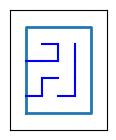


exploration gloutonne (en graphe)
	états sur le chemin vers la sortie : [(0, 0), (0, 1), (0, 2), (1, 2), (2, 2), (3, 2), (3, 1), (4, 1), (4, 2), (4, 3)]
	actions sur le chemin vers la sortie : ['D', 'D', 'B', 'B', 'B', 'G', 'B', 'D', 'D']


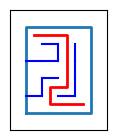

In [62]:
labProb2 = LabyrinthProblem(labyrinth=lab2)
labProb2.labyrinth.show()
print("\nexploration gloutonne (en graphe)")
res2gg, nodes_gen_gg, nodes_vis_gg = greedy_graph_search(labProb2, h=labProb2.h)
etats2gg = path_states(res2gg)
print("\tétats sur le chemin vers la sortie : " + str(etats2gg))
print("\tactions sur le chemin vers la sortie : " + str(path_actions(res2gg)))
pile_solution = Stack()
pile_solution.lst = etats2gg.copy()
labProb2.labyrinth.show(pile_solution)

#### Exploration A* (en graphe)

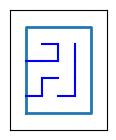


exploration A* (en graphe)
	états sur le chemin vers la sortie : [(0, 0), (0, 1), (0, 2), (0, 3), (1, 3), (2, 3), (3, 3), (4, 3)]
	actions sur le chemin vers la sortie : ['D', 'D', 'D', 'B', 'B', 'B', 'B']


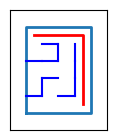

In [63]:
labProb2 = LabyrinthProblem(labyrinth=lab2)
labProb2.labyrinth.show()
print("\nexploration A* (en graphe)")
res2a, nodes_gen_a, nodes_vis_a = astar_graph_search(labProb2, h=labProb2.h)
etats2a = path_states(res2a)
print("\tétats sur le chemin vers la sortie : " + str(etats2a))
print("\tactions sur le chemin vers la sortie : " + str(path_actions(res2a)))
pile_solution = Stack()
pile_solution.lst = etats2a.copy()
labProb2.labyrinth.show(pile_solution)

### Question 12 : comparer le nombre de noeuds générés et visités, par algorithme

In [64]:
# Comparaison des performances des différents algorithmes
print("="*80)
print("COMPARAISON DES ALGORITHMES DE RECHERCHE")
print("="*80)
print()

# Tableau de comparaison
print(f"{'Algorithme':<35} | {'Noeuds générés':<15} | {'Noeuds visités':<15} | {'Longueur chemin':<15}")
print("-"*80)
print(f"{'Largeur (arbre)':<35} | {nodes_gen_bt:<15} | {nodes_vis_bt:<15} | {len(etats2bt):<15}")
print(f"{'Largeur (graphe)':<35} | {nodes_gen_bg:<15} | {nodes_vis_bg:<15} | {len(etats2bg):<15}")
print(f"{'Glouton (graphe)':<35} | {nodes_gen_gg:<15} | {nodes_vis_gg:<15} | {len(etats2gg):<15}")
print(f"{'A* (graphe)':<35} | {nodes_gen_a:<15} | {nodes_vis_a:<15} | {len(etats2a):<15}")
print()

# Analyse des résultats
print("ANALYSE DES RÉSULTATS:")
print("-"*80)
print()
print("1. Exploration en largeur (arbre vs graphe):")
print(f"   - L'exploration en arbre génère {nodes_gen_bt} noeuds et en visite {nodes_vis_bt}")
print(f"   - L'exploration en graphe génère {nodes_gen_bg} noeuds et en visite {nodes_vis_bg}")
print(f"   - Gain en utilisant le graphe: {nodes_gen_bt - nodes_gen_bg} noeuds générés en moins")
print()

print("2. Comparaison des algorithmes informés (graphe):")
print(f"   - Glouton: génère {nodes_gen_gg} noeuds, visite {nodes_vis_gg} noeuds")
print(f"   - A*: génère {nodes_gen_a} noeuds, visite {nodes_vis_a} noeuds")
print()

print("3. Optimalité de la solution:")
print(f"   - Largeur (arbre): longueur = {len(etats2bt)} (optimal)")
print(f"   - Largeur (graphe): longueur = {len(etats2bg)} (optimal)")
print(f"   - Glouton: longueur = {len(etats2gg)} (pas toujours optimal)")
print(f"   - A*: longueur = {len(etats2a)} (optimal)")
print()

print("4. Efficacité:")
print(f"   - A* est le plus efficace: trouve le chemin optimal avec seulement {nodes_gen_a} noeuds générés")
print(f"   - Glouton est rapide mais peut ne pas trouver le chemin optimal")
print(f"   - Largeur en graphe garantit l'optimalité mais explore plus de noeuds")
print()

COMPARAISON DES ALGORITHMES DE RECHERCHE

Algorithme                          | Noeuds générés  | Noeuds visités  | Longueur chemin
--------------------------------------------------------------------------------
Largeur (arbre)                     | 571             | 278             | 8              
Largeur (graphe)                    | 20              | 18              | 8              
Glouton (graphe)                    | 15              | 12              | 10             
A* (graphe)                         | 15              | 13              | 8              

ANALYSE DES RÉSULTATS:
--------------------------------------------------------------------------------

1. Exploration en largeur (arbre vs graphe):
   - L'exploration en arbre génère 571 noeuds et en visite 278
   - L'exploration en graphe génère 20 noeuds et en visite 18
   - Gain en utilisant le graphe: 551 noeuds générés en moins

2. Comparaison des algorithmes informés (graphe):
   - Glouton: génère 15 noeuds, visite

# Résolution de jeux du taquin

## Question 13 : reprener les étapes de la résolution de labyrinthe pour effectuer la résolution de jeu de taquin de taille 3x3 (pour commencer puis plus grands)

### Définition du jeu de taquin

Le jeu de taquin (ou sliding puzzle) est un puzzle où des tuiles numérotées sont placées sur une grille avec une case vide. Le but est de réorganiser les tuiles pour atteindre une configuration cible en déplaçant les tuiles adjacentes à la case vide.


In [65]:
class TaquinProblem(Problem):
    """
    Le jeu de taquin (sliding puzzle).
    Un état est représenté par un tuple de tuples, par exemple :
    ((1, 2, 3), (4, 5, 6), (7, 8, 0)) pour un puzzle 3x3
    où 0 représente la case vide.

    Les actions sont 'H' (haut), 'B' (bas), 'G' (gauche), 'D' (droite).
    """

    def __init__(self, initial, goal=None, n=3):
        """
        initial : état initial du puzzle
        goal : état but (si None, on utilise l'état résolu par défaut)
        n : taille du puzzle (n x n)
        """
        self.n = n
        if goal is None:
            # État résolu par défaut : tuiles dans l'ordre avec 0 à la fin
            goal_list = list(range(1, n*n)) + [0]
            goal = tuple(tuple(goal_list[i*n:(i+1)*n]) for i in range(n))
        super().__init__(initial, goal)

    def find_blank(self, state):
        """Trouve la position (ligne, colonne) de la case vide (0)."""
        for i in range(self.n):
            for j in range(self.n):
                if state[i][j] == 0:
                    return (i, j)
        return None

    def actions(self, state):
        """Retourne les actions possibles depuis l'état donné."""
        actions = []
        i, j = self.find_blank(state)

        # On peut déplacer une tuile vers la case vide si elle est adjacente
        if i > 0:  # On peut déplacer la tuile du haut vers le bas (case vide monte)
            actions.append('H')
        if i < self.n - 1:  # On peut déplacer la tuile du bas vers le haut (case vide descend)
            actions.append('B')
        if j > 0:  # On peut déplacer la tuile de gauche vers la droite (case vide va à gauche)
            actions.append('G')
        if j < self.n - 1:  # On peut déplacer la tuile de droite vers la gauche (case vide va à droite)
            actions.append('D')

        return actions

    def result(self, state, action):
        """Retourne l'état résultant de l'application de l'action."""
        i, j = self.find_blank(state)
        # Convertir le tuple en liste pour modification
        new_state = [list(row) for row in state]

        if action == 'H':  # La case vide monte (échange avec la tuile du haut)
            new_state[i][j], new_state[i-1][j] = new_state[i-1][j], new_state[i][j]
        elif action == 'B':  # La case vide descend (échange avec la tuile du bas)
            new_state[i][j], new_state[i+1][j] = new_state[i+1][j], new_state[i][j]
        elif action == 'G':  # La case vide va à gauche (échange avec la tuile de gauche)
            new_state[i][j], new_state[i][j-1] = new_state[i][j-1], new_state[i][j]
        elif action == 'D':  # La case vide va à droite (échange avec la tuile de droite)
            new_state[i][j], new_state[i][j+1] = new_state[i][j+1], new_state[i][j]

        # Reconvertir en tuple de tuples
        return tuple(tuple(row) for row in new_state)

    def h_manhattan(self, node):
        """
        Heuristique : distance de Manhattan.
        Somme des distances de Manhattan entre chaque tuile et sa position cible.
        """
        state = node.state
        distance = 0

        for i in range(self.n):
            for j in range(self.n):
                value = state[i][j]
                if value != 0:  # On ignore la case vide
                    # Position cible de cette valeur
                    target_i = (value - 1) // self.n
                    target_j = (value - 1) % self.n
                    # Distance de Manhattan
                    distance += abs(i - target_i) + abs(j - target_j)

        return distance

    def h_misplaced(self, node):
        """
        Heuristique : nombre de tuiles mal placées.
        Compte le nombre de tuiles qui ne sont pas à leur position cible.
        """
        state = node.state
        misplaced = 0

        for i in range(self.n):
            for j in range(self.n):
                value = state[i][j]
                if value != 0:  # On ignore la case vide
                    target_i = (value - 1) // self.n
                    target_j = (value - 1) % self.n
                    if i != target_i or j != target_j:
                        misplaced += 1

        return misplaced

    def h(self, node):
        """Heuristique par défaut : distance de Manhattan."""
        return self.h_manhattan(node)

    def display(self, state):
        """Affiche joliment l'état du puzzle."""
        print()
        for row in state:
            print("  ", end="")
            for val in row:
                if val == 0:
                    print("   ", end=" ")
                else:
                    print(f"{val:2d}", end=" ")
            print()
        print()


### Test de la classe TaquinProblem

In [66]:
# État initial simple (presque résolu)
initial_state_easy = (
    (1, 2, 3),
    (4, 5, 6),
    (7, 0, 8)
)

# État initial plus difficile
initial_state_medium = (
    (1, 2, 3),
    (4, 0, 6),
    (7, 5, 8)
)

# État initial difficile
initial_state_hard = (
    (7, 2, 4),
    (5, 0, 6),
    (8, 3, 1)
)

# Création du problème
taquin_easy = TaquinProblem(initial_state_easy)

print("État initial (facile):")
taquin_easy.display(initial_state_easy)

print("État but:")
taquin_easy.display(taquin_easy.goal)

# Test des méthodes
print("Position de la case vide:", taquin_easy.find_blank(initial_state_easy))
print("Actions possibles:", taquin_easy.actions(initial_state_easy))

# Test de result()
new_state = taquin_easy.result(initial_state_easy, 'D')
print("Après action 'D' (droite):")
taquin_easy.display(new_state)

# Test des heuristiques
init_node = Node(initial_state_easy)
print(f"Heuristique Manhattan: {taquin_easy.h_manhattan(init_node)}")
print(f"Heuristique tuiles mal placées: {taquin_easy.h_misplaced(init_node)}")


État initial (facile):

   1  2  3 
   4  5  6 
   7      8 

État but:

   1  2  3 
   4  5  6 
   7  8     

Position de la case vide: (2, 1)
Actions possibles: ['H', 'G', 'D']
Après action 'D' (droite):

   1  2  3 
   4  5  6 
   7  8     

Heuristique Manhattan: 1
Heuristique tuiles mal placées: 1


### Résolution avec différents algorithmes

#### Test 1 : Problème facile avec exploration en largeur (graphe)

In [67]:
print("="*80)
print("TEST 1 : Problème FACILE avec exploration en largeur (graphe)")
print("="*80)

taquin_easy = TaquinProblem(initial_state_easy)
print("\nÉtat initial:")
taquin_easy.display(initial_state_easy)

result_bg, nodes_gen_bg, nodes_vis_bg = breadth_first_graph_search(taquin_easy)

if result_bg != failure:
    solution_states = path_states(result_bg)
    solution_actions = path_actions(result_bg)

    print(f"\nSolution trouvée en {len(solution_actions)} coups!")
    print(f"Noeuds générés: {nodes_gen_bg}")
    print(f"Noeuds visités: {nodes_vis_bg}")
    print(f"\nActions: {solution_actions}")

    print("\nChemin de la solution:")
    for i, state in enumerate(solution_states):
        if i < len(solution_actions):
            print(f"Étape {i} - Action: {solution_actions[i] if i > 0 else 'Initial'}")
        else:
            print(f"Étape {i} - État final")
        taquin_easy.display(state)
else:
    print("Aucune solution trouvée!")


TEST 1 : Problème FACILE avec exploration en largeur (graphe)

État initial:

   1  2  3 
   4  5  6 
   7      8 


Solution trouvée en 1 coups!
Noeuds générés: 8
Noeuds visités: 4

Actions: ['D']

Chemin de la solution:
Étape 0 - Action: Initial

   1  2  3 
   4  5  6 
   7      8 

Étape 1 - État final

   1  2  3 
   4  5  6 
   7  8     



#### Test 2 : Problème facile avec exploration A* (graphe)

In [68]:
print("="*80)
print("TEST 2 : Problème FACILE avec exploration A* (graphe)")
print("="*80)

taquin_easy = TaquinProblem(initial_state_easy)
print("\nÉtat initial:")
taquin_easy.display(initial_state_easy)

result_a, nodes_gen_a, nodes_vis_a = astar_graph_search(taquin_easy, h=taquin_easy.h_manhattan)

if result_a != failure:
    solution_states = path_states(result_a)
    solution_actions = path_actions(result_a)

    print(f"\nSolution trouvée en {len(solution_actions)} coups!")
    print(f"Noeuds générés: {nodes_gen_a}")
    print(f"Noeuds visités: {nodes_vis_a}")
    print(f"\nActions: {solution_actions}")

    print("\nChemin de la solution:")
    for i, state in enumerate(solution_states):
        if i < len(solution_actions):
            print(f"Étape {i} - Action: {solution_actions[i] if i > 0 else 'Initial'}")
        else:
            print(f"Étape {i} - État final")
        taquin_easy.display(state)
else:
    print("Aucune solution trouvée!")


TEST 2 : Problème FACILE avec exploration A* (graphe)

État initial:

   1  2  3 
   4  5  6 
   7      8 


Solution trouvée en 1 coups!
Noeuds générés: 4
Noeuds visités: 2

Actions: ['D']

Chemin de la solution:
Étape 0 - Action: Initial

   1  2  3 
   4  5  6 
   7      8 

Étape 1 - État final

   1  2  3 
   4  5  6 
   7  8     



#### Test 3 : Problème moyen avec A* et différentes heuristiques

In [69]:
print("="*80)
print("TEST 3 : Problème MOYEN - Comparaison des heuristiques avec A*")
print("="*80)

taquin_medium = TaquinProblem(initial_state_medium)
print("\nÉtat initial:")
taquin_medium.display(initial_state_medium)

# Test avec heuristique Manhattan
print("\n--- Avec heuristique Manhattan ---")
result_a_manhattan, nodes_gen_manhattan, nodes_vis_manhattan = astar_graph_search(
    taquin_medium, h=taquin_medium.h_manhattan
)

if result_a_manhattan != failure:
    solution_actions_manhattan = path_actions(result_a_manhattan)
    print(f"Solution trouvée en {len(solution_actions_manhattan)} coups")
    print(f"Noeuds générés: {nodes_gen_manhattan}")
    print(f"Noeuds visités: {nodes_vis_manhattan}")
    print(f"Actions: {solution_actions_manhattan}")

# Test avec heuristique tuiles mal placées
print("\n--- Avec heuristique tuiles mal placées ---")
result_a_misplaced, nodes_gen_misplaced, nodes_vis_misplaced = astar_graph_search(
    taquin_medium, h=taquin_medium.h_misplaced
)

if result_a_misplaced != failure:
    solution_actions_misplaced = path_actions(result_a_misplaced)
    print(f"Solution trouvée en {len(solution_actions_misplaced)} coups")
    print(f"Noeuds générés: {nodes_gen_misplaced}")
    print(f"Noeuds visités: {nodes_vis_misplaced}")
    print(f"Actions: {solution_actions_misplaced}")

print("\n--- Comparaison ---")
print(f"{'Heuristique':<25} | {'Noeuds générés':<15} | {'Noeuds visités':<15} | {'Longueur solution':<20}")
print("-"*80)
print(f"{'Manhattan':<25} | {nodes_gen_manhattan:<15} | {nodes_vis_manhattan:<15} | {len(solution_actions_manhattan):<20}")
print(f"{'Tuiles mal placées':<25} | {nodes_gen_misplaced:<15} | {nodes_vis_misplaced:<15} | {len(solution_actions_misplaced):<20}")


TEST 3 : Problème MOYEN - Comparaison des heuristiques avec A*

État initial:

   1  2  3 
   4      6 
   7  5  8 


--- Avec heuristique Manhattan ---
Solution trouvée en 2 coups
Noeuds générés: 7
Noeuds visités: 3
Actions: ['B', 'D']

--- Avec heuristique tuiles mal placées ---
Solution trouvée en 2 coups
Noeuds générés: 7
Noeuds visités: 3
Actions: ['B', 'D']

--- Comparaison ---
Heuristique               | Noeuds générés  | Noeuds visités  | Longueur solution   
--------------------------------------------------------------------------------
Manhattan                 | 7               | 3               | 2                   
Tuiles mal placées        | 7               | 3               | 2                   


#### Test 4 : Problème difficile avec A* (Manhattan)

In [73]:
print("="*80)
print("TEST 4 : Problème DIFFICILE avec A* (heuristique Manhattan)")
print("="*80)

taquin_hard = TaquinProblem(initial_state_hard)
print("\nÉtat initial:")
taquin_hard.display(initial_state_hard)

print("Résolution en cours... (cela peut prendre un peu de temps)")
result_hard, nodes_gen_hard, nodes_vis_hard = astar_graph_search(
    taquin_hard, h=taquin_hard.h_manhattan
)

if result_hard != failure:
    solution_states_hard = path_states(result_hard)
    solution_actions_hard = path_actions(result_hard)

    print(f"\nSolution trouvée en {len(solution_actions_hard)} coups!")
    print(f"Noeuds générés: {nodes_gen_hard}")
    print(f"Noeuds visités: {nodes_vis_hard}")
    print(f"\nActions: {solution_actions_hard}")

    print("\nAffichage des premières étapes:")
    for i in range(min(5, len(solution_states_hard))):
        state = solution_states_hard[i]
        if i < len(solution_actions_hard):
            print(f"Étape {i} - Action: {solution_actions_hard[i] if i > 0 else 'Initial'}")
        taquin_hard.display(state)

    if len(solution_states_hard) > 5:
        print(f"... ({len(solution_states_hard) - 5} étapes supplémentaires)")
        print("\nÉtat final:")
        taquin_hard.display(solution_states_hard[-1])
else:
    print("Aucune solution trouvée!")


TEST 4 : Problème DIFFICILE avec A* (heuristique Manhattan)

État initial:

   7  2  4 
   5      6 
   8  3  1 

Résolution en cours... (cela peut prendre un peu de temps)

Solution trouvée en 20 coups!
Noeuds générés: 452
Noeuds visités: 283

Actions: ['B', 'D', 'H', 'G', 'G', 'H', 'D', 'D', 'B', 'G', 'B', 'G', 'H', 'D', 'H', 'G', 'B', 'D', 'D', 'B']

Affichage des premières étapes:
Étape 0 - Action: Initial

   7  2  4 
   5      6 
   8  3  1 

Étape 1 - Action: D

   7  2  4 
   5  3  6 
   8      1 

Étape 2 - Action: H

   7  2  4 
   5  3  6 
   8  1     

Étape 3 - Action: G

   7  2  4 
   5  3     
   8  1  6 

Étape 4 - Action: G

   7  2  4 
   5      3 
   8  1  6 

... (16 étapes supplémentaires)

État final:

   1  2  3 
   4  5  6 
   7  8     



#### Test 5 : Comparaison des algorithmes sur le problème moyen

In [74]:
print("="*80)
print("TEST 5 : COMPARAISON DES ALGORITHMES sur problème moyen")
print("="*80)

taquin_medium = TaquinProblem(initial_state_medium)
print("\nÉtat initial:")
taquin_medium.display(initial_state_medium)

# Largeur (graphe)
print("\n1. Exploration en largeur (graphe)...")
result_bg, nodes_gen_bg, nodes_vis_bg = breadth_first_graph_search(taquin_medium)
len_bg = len(path_actions(result_bg)) if result_bg != failure else -1

# Glouton avec Manhattan
print("2. Exploration gloutonne (graphe, Manhattan)...")
result_gg, nodes_gen_gg, nodes_vis_gg = greedy_graph_search(
    taquin_medium, h=taquin_medium.h_manhattan
)
len_gg = len(path_actions(result_gg)) if result_gg != failure else -1

# A* avec Manhattan
print("3. A* (graphe, Manhattan)...")
result_a, nodes_gen_a, nodes_vis_a = astar_graph_search(
    taquin_medium, h=taquin_medium.h_manhattan
)
len_a = len(path_actions(result_a)) if result_a != failure else -1

# Tableau récapitulatif
print("\n" + "="*100)
print("RÉSULTATS DE LA COMPARAISON")
print("="*100)
print(f"{'Algorithme':<30} | {'Noeuds générés':<15} | {'Noeuds visités':<15} | {'Longueur solution':<20}")
print("-"*100)
print(f"{'Largeur (graphe)':<30} | {nodes_gen_bg:<15} | {nodes_vis_bg:<15} | {len_bg:<20}")
print(f"{'Glouton (Manhattan)':<30} | {nodes_gen_gg:<15} | {nodes_vis_gg:<15} | {len_gg:<20}")
print(f"{'A* (Manhattan)':<30} | {nodes_gen_a:<15} | {nodes_vis_a:<15} | {len_a:<20}")

print("\nCONCLUSIONS:")
print("-"*100)
print("1. L'exploration en largeur garantit l'optimalité mais explore beaucoup de noeuds.")
print("2. L'exploration gloutonne est rapide mais peut ne pas trouver la solution optimale.")
print("3. A* combine le meilleur des deux : trouve la solution optimale avec moins de noeuds explorés.")
print("4. L'heuristique de Manhattan est admissible et performante pour le jeu de taquin.")


TEST 5 : COMPARAISON DES ALGORITHMES sur problème moyen

État initial:

   1  2  3 
   4      6 
   7  5  8 


1. Exploration en largeur (graphe)...
2. Exploration gloutonne (graphe, Manhattan)...
3. A* (graphe, Manhattan)...

RÉSULTATS DE LA COMPARAISON
Algorithme                     | Noeuds générés  | Noeuds visités  | Longueur solution   
----------------------------------------------------------------------------------------------------
Largeur (graphe)               | 16              | 9               | 2                   
Glouton (Manhattan)            | 7               | 3               | 2                   
A* (Manhattan)                 | 7               | 3               | 2                   

CONCLUSIONS:
----------------------------------------------------------------------------------------------------
1. L'exploration en largeur garantit l'optimalité mais explore beaucoup de noeuds.
2. L'exploration gloutonne est rapide mais peut ne pas trouver la solution optimale.
3

### Extension : Taquin 4x4

In [75]:
print("="*80)
print("BONUS : Taquin 4x4")
print("="*80)

# État initial pour un taquin 4x4 (peu mélangé)
initial_state_4x4 = (
    (1, 2, 3, 4),
    (5, 6, 7, 8),
    (9, 10, 11, 12),
    (13, 0, 14, 15)
)

taquin_4x4 = TaquinProblem(initial_state_4x4, n=4)

print("\nÉtat initial (4x4):")
taquin_4x4.display(initial_state_4x4)

print("État but (4x4):")
taquin_4x4.display(taquin_4x4.goal)

print("\nRésolution avec A* (Manhattan)...")
result_4x4, nodes_gen_4x4, nodes_vis_4x4 = astar_graph_search(
    taquin_4x4, h=taquin_4x4.h_manhattan
)

if result_4x4 != failure:
    solution_actions_4x4 = path_actions(result_4x4)
    print(f"\nSolution trouvée en {len(solution_actions_4x4)} coups!")
    print(f"Noeuds générés: {nodes_gen_4x4}")
    print(f"Noeuds visités: {nodes_vis_4x4}")
    print(f"Actions: {solution_actions_4x4}")
else:
    print("Aucune solution trouvée!")


BONUS : Taquin 4x4

État initial (4x4):

   1  2  3  4 
   5  6  7  8 
   9 10 11 12 
  13     14 15 

État but (4x4):

   1  2  3  4 
   5  6  7  8 
   9 10 11 12 
  13 14 15     


Résolution avec A* (Manhattan)...

Solution trouvée en 2 coups!
Noeuds générés: 6
Noeuds visités: 3
Actions: ['D', 'D']
